<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Car-Pole-Example" data-toc-modified-id="Car-Pole-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Car Pole Example</a></span><ul class="toc-item"><li><span><a href="#Pure-Randomness" data-toc-modified-id="Pure-Randomness-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Pure Randomness</a></span></li><li><span><a href="#Pole-Velocity-Error" data-toc-modified-id="Pole-Velocity-Error-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pole Velocity Error</a></span></li><li><span><a href="#Random-Search" data-toc-modified-id="Random-Search-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Search</a></span></li><li><span><a href="#Q-Learning:-Tabular-Method" data-toc-modified-id="Q-Learning:-Tabular-Method-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Q-Learning: Tabular Method</a></span><ul class="toc-item"><li><span><a href="#Limits-and-Bins" data-toc-modified-id="Limits-and-Bins-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Limits and Bins</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#RBF-NNs-&amp;-Q-Learning" data-toc-modified-id="RBF-NNs-&amp;-Q-Learning-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>RBF NNs &amp; Q-Learning</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li></ul></li></ul></div>

# Car Pole Example

The main idea of this notebook is to interact with the `car_pole` from [Open AI Gym](https://gym.openai.com/) and treat different algorithms for this problem.

In [2]:
#Loading the required libreries
import gym
import numpy as np
import itertools
import math
import pandas as pd
import random
import io
import re
import base64
import os
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, permutations


from gym import wrappers
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

## Functions 

This section has all the function that I will use in the notebook.

In [2]:
#Genera un expand_grid para hacer validacion cruzada
def expand_grid(*itrs):
   product = list(itertools.product(*itrs))
   return pd.DataFrame({'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))})

In [3]:
def plot_running_avg(total_rewards):
    n = len(total_rewards)
    running_avg = []
    for idx in range(1,n):
        running_avg.append(total_rewards[max(0,idx-100):idx].mean())
    plt.plot(running_avg)
    plt.title('RUNNIN AVERAGE')
    plt.show()

In [1]:
def sorted_nicely(l):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

## Car Pole Example

This section covers the `car_pole` example.

In [4]:
#My envorinement
game = 'Car Pole'
my_env = gym.make('CartPole-v0')
# my_env = wrappers.Monitor(my_env, '../Gym Videos/' + game, force=True)

In [5]:
#Reset the game, the car in this case
my_env.reset()

array([ 0.02630571, -0.00067484, -0.00423601, -0.02619028])

### Pure Randomness

Here we do 1000 iterations and average the result just picking an action between 0 and 1 randomly.

In [6]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(100):
    my_env.reset()
    done = False
    steps = 0
    while not done:
#         my_env.render()
        obs, rew, done, _ = my_env.step(action=my_env.action_space.sample())
        steps += 1
    steps_array.append(steps)
my_env.close()

print('AVERAGE OF STEPS:', np.mean(steps_array))
print('STD OF STEPS:', np.round(np.std(steps_array), 2))

AVERAGE OF STEPS: 23.64
STD OF STEPS: 12.39


### Pole Velocity Error

This section pick an action based on the error function $E = p^2$ where $p$ is the pole velocity. I define the error in that way since we want a low pole velocity. Again, we do 1000 iterations an average the results.

In [8]:
#Define an error function using the pole velocity as the unique parameter to penalize the model
def error_function(obs):
    pos, vel, angle, pole_vel = obs
    error = (pole_vel**2)
    return error

In [9]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(1000):
    my_env.reset()
    action = my_env.action_space.sample()
    previous_error = -math.inf
    done = False
    steps = 0
    while not done:
#         my_env.render()
        obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        new_error = error_function(obs)
        if new_error < previous_error:
            previous_error = new_error
            pass
        else:
            previous_error = new_error
            action = abs(action-1)
            
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2))
print('STD OF STEPS:', np.round(np.std(steps_array), 2))

AVERAGE OF STEPS: 158.79
STD OF STEPS: 22.46


Using this error function is clear that the number of steps is greater (much greater) that the randomness algorithm in average. Now, how can we improve the new record? 

As we can see in the video, what happens is that the car arrives at one the corners and die. So, my idea is to use the `position`  in a new error function.

In [10]:
#Define an error function using the pole velocity as the unique parameter to penalize the model
def error_function(obs):
    pos, vel, angle, pole_vel = obs
    error = ((pos*pole_vel)**2)
    return error

In [11]:
#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
steps_array = []
for i in range(1000):
    my_env.reset()
    action = my_env.action_space.sample()
    previous_error = -math.inf
    done = False
    steps = 0
    while not done:
#         my_env.render()
        obs, rew, done, _ = my_env.step(action=action)
        steps += 1
        new_error = error_function(obs)
        if new_error < previous_error:
            previous_error = new_error
            pass
        else:
            previous_error = new_error
            action = abs(action-1)
            
    steps_array.append(steps)
# my_env.close()
print('AVERAGE OF STEPS:', np.round(np.mean(steps_array), 2))
print('STD OF STEPS:', np.round(np.std(steps_array), 2))

AVERAGE OF STEPS: 161.93
STD OF STEPS: 26.95


In [12]:
#See the videos in the cell of jupyter
mp4_files = os.listdir('../Gym Videos/' + game)
mp4_files = [f for f in mp4_files if f.endswith('mp4')]

#PICK ONE THE VIDEOS
f = mp4_files[1]
#Example of Video
video = io.open('../Gym Videos/' + game + '/' + f, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

### Random Search

Now we will implement a random search for the weights of a linear model with the parameters of the car i.e.

$$a = \sigma(w_0 + w_1p_v + w_2p_a + w_3c_v + w_4c_p)$$

In [60]:
def assign_action(obs, weights):
    y = np.dot(obs, weights)
    if y > 0:
        return 0
    return 1

In [61]:
#Vectors and values relevant for final analysis
steps_best_sample = None
steps_best_avg = -math.inf
step_avgs = []
best_weights = None

#init my_env
obs = my_env.reset()

for r_i in range(1000):
    
    #Init random weights between [-1,1] for each one of the parameters of the models
    random_weights = np.random.random(len(obs))*2 - 1 

    steps_reps = []
    for i in range(100):
        obs = my_env.reset()
        done = False
        steps = 0
        while not done:
            steps += 1
            action = assign_action(obs, weights=random_weights)
            obs, rew, done, _ = my_env.step(action=action)
        steps_reps.append(steps)
    
    step_avgs.append(np.mean(steps_reps))
    if np.mean(steps_reps) > steps_best_avg:
        steps_best_avg = np.mean(steps_reps)
        steps_best_sample = steps_reps
        best_weights = random_weights
    
    if (r_i+1) % 50 == 0:
        print('ITERATION NUMBER', r_i+1)


ITERATION NUMBER 50
ITERATION NUMBER 100
ITERATION NUMBER 150
ITERATION NUMBER 200
ITERATION NUMBER 250
ITERATION NUMBER 300
ITERATION NUMBER 350
ITERATION NUMBER 400
ITERATION NUMBER 450
ITERATION NUMBER 500
ITERATION NUMBER 550
ITERATION NUMBER 600
ITERATION NUMBER 650
ITERATION NUMBER 700
ITERATION NUMBER 750
ITERATION NUMBER 800
ITERATION NUMBER 850
ITERATION NUMBER 900
ITERATION NUMBER 950
ITERATION NUMBER 1000


In [62]:
print('BEST AVERAGE', steps_best_avg, 'WITH WEIGHTS', best_weights)

BEST AVERAGE 200.0 WITH WEIGHTS [-0.15331426  0.03164042 -0.96412202 -0.38947862]


Pretty cool, random search for weights of linear model does work very well, as a matter of fact, achieves perfection i.e. the maximum number of steps: 200.

### Q-Learning: Tabular Method

Let's implement the tabular method.

#### Limits and Bins

Construction of the bins for each one of the parameters of the model. In particular, given that `pole_vel` and `car_vel` do not have intervals, we will iterate and calculate the `min` and `max`.

In [7]:
min_pos, max_pos = [-2.4,2.4]
min_vel, max_vel = [-2, 2]
min_angle, max_angle = [-0.4, 0.4]
min_pole_vel, max_pole_vel = [-3.5, 3.5]

#Exercise: Determine how many steps, on average, are taken, when
#actions are randomly sampled
vels = []
pole_vels = []
angles = []
for i in range(1000):
    my_env.reset()
    done = False
    steps = 0
    while not done:
        obs, rew, done, _ = my_env.step(action=my_env.action_space.sample())
        steps += 1
        vels.append(obs[1])
        angles.append(obs[2])
        pole_vels.append(obs[3])
my_env.close()

In [8]:
epsilon = .01
min_vel, max_vel = -max(np.abs(vels)) - epsilon, max(np.abs(vels)) + epsilon
min_pole_vel, max_pole_vel = -max(np.abs(pole_vels)) - epsilon, max(np.abs(pole_vels)) + epsilon
min_angle, max_angle = -max(np.abs(angles)) - epsilon, max(np.abs(angles)) + epsilon
print('MIN VEL:', min_vel, 'MAX VEL:',max_vel)
print('MIN POLE VEL:', min_pole_vel, 'MAX POLE VEL:', max_pole_vel)
print('MIN ANGLE:', min_angle, 'MAX ANGLE:', max_angle)

MIN VEL: -2.679293322690264 MAX VEL: 2.679293322690264
MIN POLE VEL: -3.457633464710429 MAX POLE VEL: 3.457633464710429
MIN ANGLE: -0.2694583588702886 MAX ANGLE: 0.2694583588702886


Now, we have the limit for our `box`.

In [53]:
#Define the bins for each one of the parameters
num_bins = 8
pos_bins = np.linspace(min_pos, max_pos, num_bins)
vel_bins = np.linspace(min_vel, max_vel, num_bins)
angle_bins = np.linspace(min_angle, max_angle, num_bins)
pole_vel_bins = np.linspace(min_pole_vel, max_pole_vel, num_bins)

#Creates a list with the bins of each parameters in the order that the parameters are presented
obs_bins = [pos_bins, vel_bins, angle_bins, pole_vel_bins]

#### Functions

Let's create some relevant classes for the __Tabular Method__.

In [54]:
def construct_q_tab(env, number_of_bins, randomness=True):
    n_obs = env.observation_space.shape[0]
    n_obs_bins = (number_of_bins+1)**n_obs
    n_actions = env.action_space.n
    
    q_tab = np.random.uniform(-1,1, size=(n_obs_bins, n_actions))
    q_tab = pd.DataFrame(q_tab)
    
    str_l = list(range(0,number_of_bins+1))
    combinations = set(list(combinations_with_replacement(str_l*n_obs, n_obs)))
    combinations_join = ['-'.join([str(n) for n in c]) for c in combinations]
    
    q_tab['INDEX'] = combinations_join
    
    q_tab = q_tab.set_index('INDEX')
    return q_tab

def build_state(states):
    states_str = '-'.join([str(int(s)) for s in states])
    return states_str

def to_bin(value, my_bin):
    return np.digitize(value, my_bin)

def transform_obs(obs, obs_bins=obs_bins):
    if len(obs) != len(obs_bins):
        return 'ERROR'
    else:
        obs_to_bins = []
        for idx,_ in enumerate(obs):
            obs_to_bins.append(to_bin(obs[idx], obs_bins[idx]))
        return build_state(obs_to_bins)

def predict(state, q_tab):
    x = transform_obs(state)
    return np.array(q_tab.loc[x])

def update(state, a, g, q_tab, l_r=0.01):
    x = transform_obs(state)
    q_tab.loc[x, a] += l_r*(g - q_tab.loc[x, a])
    
def sample_action(env, state, eps, q_tab):
    if np.random.random() < eps:
        return env.action_space.sample()
    else:
        a_p = predict(state, q_tab)
        return np.argmax(np.array(a_p))

In [59]:
q_tab = construct_q_tab(env=my_env, number_of_bins=num_bins)

print('SHAPE OF Q-TAB IS', q_tab.shape)

SHAPE OF Q-TAB IS (6561, 2)


In [60]:
def play_game(env, q_tab, eps, gamma):
    obs = env.reset()
    done = False
    steps = 0
    total_reward = 0
    
    while not done:
        ac = sample_action(env, state=obs, eps=eps, q_tab=q_tab)
        pre_obs = obs.copy()
        obs, rew, done, _ = my_env.step(action=ac)
        total_reward += rew
        
        if (steps < 199) and done:
            rew = -10000
           
        #Update the model
        g = rew + gamma*np.max(predict(obs, q_tab))
        update(state=pre_obs, a=ac, g=g, q_tab=q_tab)
        
        steps += 1
        
    return total_reward

In [61]:
## ITERATE AND LEARN
total_rewards = []
gamma = 0.9

for i in range(10000):
    eps = 1.0/np.sqrt(i+1)
    total_reward = play_game(env=my_env, q_tab=q_tab, eps=eps, gamma=gamma)
    total_rewards.append(total_reward)
    if (i+1) % 250 == 0:
        print(i+1, 'ITERATION -', np.mean(total_rewards[i-99:i+1]), 'TOTAL REWARD')

250 ITERATION - 121.01 TOTAL REWARD
500 ITERATION - 176.1 TOTAL REWARD
750 ITERATION - 189.46 TOTAL REWARD
1000 ITERATION - 193.35 TOTAL REWARD
1250 ITERATION - 194.7 TOTAL REWARD
1500 ITERATION - 190.85 TOTAL REWARD
1750 ITERATION - 190.85 TOTAL REWARD
2000 ITERATION - 195.47 TOTAL REWARD
2250 ITERATION - 194.85 TOTAL REWARD
2500 ITERATION - 199.64 TOTAL REWARD
2750 ITERATION - 200.0 TOTAL REWARD
3000 ITERATION - 199.85 TOTAL REWARD
3250 ITERATION - 200.0 TOTAL REWARD
3500 ITERATION - 200.0 TOTAL REWARD
3750 ITERATION - 200.0 TOTAL REWARD
4000 ITERATION - 200.0 TOTAL REWARD
4250 ITERATION - 200.0 TOTAL REWARD
4500 ITERATION - 200.0 TOTAL REWARD
4750 ITERATION - 200.0 TOTAL REWARD
5000 ITERATION - 200.0 TOTAL REWARD
5250 ITERATION - 200.0 TOTAL REWARD
5500 ITERATION - 200.0 TOTAL REWARD
5750 ITERATION - 200.0 TOTAL REWARD
6000 ITERATION - 200.0 TOTAL REWARD
6250 ITERATION - 200.0 TOTAL REWARD
6500 ITERATION - 200.0 TOTAL REWARD
6750 ITERATION - 200.0 TOTAL REWARD
7000 ITERATION - 193.5

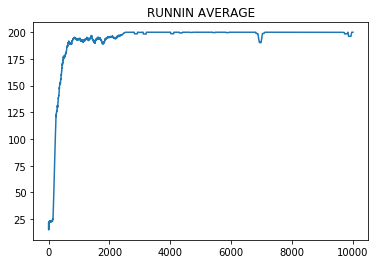

In [62]:
#We plot the Moving Average
plot_running_avg(np.array(total_rewards))

### RBF NNs & Q-Learning

#### Functions

In [157]:
def sampler_observations(env, sample_size, standardize=True):
    '''
    Generates a sample of states of an environement or game
    '''
    n_obs = len(env.reset())
    sample = np.random.random((sample_size, n_obs))*2 - 2
    if standardize:
        scaler = StandardScaler()
        scaled_sample = scaler.fit_transform(sample)
        dic = {'SCALER': scaler, 'SAMPLE': sample, 'SCALED_SAMPLE': scaled_sample}
    else:
        dic = {'SCALER': scaler, 'SAMPLE': sample}
    print('GENERATED DATA WITH SHAPE', sample.shape)
    return dic

In [158]:
def rbf_featurizer(data, gammas, num_components):
    '''
    Generates a rbf featurizer for different gammas (variances) and fit data with it
    '''
    features = []
    for idx, g in enumerate(gammas):
        rbf_name = 'RBF-' + str(idx)
        s = RBFSampler(gamma=g, n_components=num_components)
        rbf = (rbf_name, s)
        features.append(rbf)
    featurizer = FeatureUnion(features)
    t_features = featurizer.fit_transform(data)
    dic = {'FEATURIZER': featurizer, 'TRANSFORM_FEATURES': t_features}
    return dic

In [159]:
class sgd_regressor():
    def __init__(self, n_weights, l_r=0.01, learning_method='invscaling', power_t=0.25):
        self.weights = np.random.rand(n_weights)/np.power(n_weights, 0.5)
        self.l_r = l_r
        self.learning_method = learning_method
        self.step = 0
        self.power_t = power_t
        
    
    def partial_fit(self, x, y):
        estimated = x.dot(self.weights)
        gradient = (y - estimated).dot(x)
        self.weights += (self.l_r)*gradient
        self.step += 1
        if self.learning_method == 'invscaling':
            self.l_r /= math.pow(self.step, self.power_t)
    
    def predict(self, x):
        return x.dot(self.weights)

def init_models(env, n_weights, featurizer, scaler, n_actions=None, l_r=0.01, learning_method='invscaling'):
    models = []
    if n_actions==None:
        n_actions = env.action_space.n
    
    for i in range(n_actions):
        model = sgd_regressor(n_weights=n_weights, l_r=l_r, learning_method=learning_method)
        state_scaled = scaler.transform([env.reset()])
        state_feature = featurizer.transform(state_scaled)
        models.append(model)
    return models

def predict(state, featurizer, scaler, models):
    state_scaled = scaler.transform(np.atleast_2d(state))
    state_feature = featurizer.transform(state_scaled)
    #assert(len(state_feature.shape) == 2)
    predictions = np.array([m.predict(state_feature)[0] for m in models])
    return predictions

def update(state, idx_a, g, featurizer, scaler, models):
    state_scaled = scaler.transform(np.atleast_2d(state))
    state_feature = featurizer.transform(state_scaled)
    #assert(len(state_feature.shape) == 2)
    models[idx_a].partial_fit(x=state_feature, y=[g])
    
def sample_action(env, state, featurizer, scaler, models, eps, actions=None):
    if sum(actions == None) != 0:
        actions = np.array(list(range(0,env.action_space.n)))
    if np.random.random() < eps:
        idx = np.random.choice(len(actions), size=1)[0]
        return [actions[idx], idx]
    else:
        predictions = predict(state, featurizer, scaler, models)
        
        return [actions[np.argmax(predictions)], np.argmax(predictions)]

In [162]:
def play_game(env, models, featurizer, scaler, eps, gamma, n_actions=None, actions=None, updt=True):
    obs = env.reset()
    done = False
    steps = 0
    
    while not done:
        ac, idx_ac = sample_action(env=env, state=obs, featurizer=featurizer, scaler=scaler,
                                   models=models, eps=eps, actions=actions)
        pre_obs = obs.copy()
        obs, rew, done, _ = my_env.step(action=ac)
        
        if done and (steps < 199):
            rew = -10000
        elif steps == 199:
            rew = 100
        
        #Update the model
        if updt:
            g = rew + gamma*np.max(predict(state=obs, featurizer=featurizer, scaler=scaler, models=models))
            update(state=pre_obs, idx_a=idx_ac, g=g, featurizer=featurizer, scaler=scaler, models=models)
        
        steps += 1
    return steps

In [170]:
#ITERATE AND LEARN
total_rewards = []
l_r = 0.1
learning_method = 'constant'

#GENERATE SAMPLES
iterations = 1000
size = 50000
sample = sampler_observations(env=my_env, sample_size=size)
actions = np.array([0,1])
printer = 100

sample_data = sample['SCALED_SAMPLE']
scaler = sample['SCALER']
featurization = rbf_featurizer(data=sample_data, gammas=[0.75, 0.5, 0.25, 0.125],
                               num_components=1000)
featurizer = featurization['FEATURIZER']
n_weights = featurization['TRANSFORM_FEATURES'].shape[1]
models = init_models(env=my_env, n_weights=n_weights, featurizer=featurizer, scaler=scaler, l_r=l_r,
                     n_actions=len(actions), learning_method=learning_method)

'''
ITERATE AND LEARN USING RBF NN'S
'''
print('READY TO LEARN---')
for i in range(iterations):
    eps = 1/np.sqrt(i+1)
    gamma = 0.9
    total_reward = play_game(env=my_env, models=models, featurizer=featurizer, scaler=scaler,
                             eps=eps, gamma=gamma, n_actions=len(actions), actions=actions)
    total_rewards.append(total_reward)
    
    if (i+1) % printer == 0:
        print(i+1, 'ITERATION -', np.mean(total_rewards[i-(printer-1):i+1]),
              str(printer) + '-MOVING AVG REWARD')

GENERATED DATA WITH SHAPE (50000, 4)
READY TO LEARN---
100 ITERATION - 112.56 100-MOVING AVG REWARD
200 ITERATION - 200.0 100-MOVING AVG REWARD
300 ITERATION - 200.0 100-MOVING AVG REWARD
400 ITERATION - 200.0 100-MOVING AVG REWARD
500 ITERATION - 200.0 100-MOVING AVG REWARD
600 ITERATION - 200.0 100-MOVING AVG REWARD
700 ITERATION - 200.0 100-MOVING AVG REWARD
800 ITERATION - 200.0 100-MOVING AVG REWARD
900 ITERATION - 200.0 100-MOVING AVG REWARD
1000 ITERATION - 200.0 100-MOVING AVG REWARD


In [171]:
#ITERATE AND CHECK
total_rewards = []
printer = 25
eps = -1

#GENERATE SAMPLES
iterations = 100
'''
ITERATE AND CHECK USING RBF NN'S
'''
print('READY TO CHECK---')
for i in range(iterations):
    total_reward = play_game(env=my_env, models=models, featurizer=featurizer, scaler=scaler,
                             eps=eps, gamma=gamma, n_actions=len(actions), actions=actions, updt=False)
    total_rewards.append(total_reward)
    
    if (i+1) % printer == 0:
        print('ITERATION', i+1)

print('RESULTS---')
print('AVERAGE OF REWARD:', np.round(np.mean(total_rewards), 2))
print('STD OF REWARD:', np.round(np.std(total_rewards), 2))
print('MINIMUM OF REWARD:', np.round(np.min(total_rewards), 2))
print('MAXIMUM OF REWARD:', np.round(np.max(total_rewards), 2))

READY TO CHECK---
ITERATION 25
ITERATION 50
ITERATION 75
ITERATION 100
RESULTS---
AVERAGE OF REWARD: 200.0
STD OF REWARD: 0.0
MINIMUM OF REWARD: 200
MAXIMUM OF REWARD: 200


Amazing results produced by our __RBF Neural Network__ with a perfect avergare reward.